# Generate music with an LSTM

## Setup


In [1]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [2]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import pandas as pd
import numpy as np
from collections import Counter
import pretty_midi
import collections
from sklearn.model_selection import train_test_split

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the Maestro dataset

In [4]:
data_dir = pathlib.Path('/kaggle/input/classical-music-midi')
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 292


In [5]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [9]:
sample_file = filenames[0]

## Extract notes

In [10]:
# !pip install music21
from music21 import converter, key

def determine_key(midi_file):
    midi = converter.parse(midi_file)
    key_signature = midi.analyze('key')
    return key_signature

key_signature = determine_key(sample_file)
print(key_signature)

/usr/local/lib/python3.10/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


a minor


In [11]:
import mido

def extract_tempo_from_midi(file_path):
    mid = mido.MidiFile(file_path)

    for msg in mid:
        if msg.type == 'set_tempo':
            tempo_microseconds = msg.tempo
            bpm = 60000000 / tempo_microseconds
            return bpm
    return None

tempo = extract_tempo_from_midi(sample_file)
print(f'Tempo: {tempo} BPM')

Tempo: 72.9699752875017 BPM


In [12]:
from music21 import duration

all_durations = duration.typeFromNumDict

excluded_durations = {'breve', 'longa', 'maxima', 'duplex-maxima', 'zero'}

valid_durations = {
    value: name
    for value, name in all_durations.items()
    if name not in excluded_durations
}
valid_durations

{1.0: 'whole',
 2.0: 'half',
 4.0: 'quarter',
 8.0: 'eighth',
 16.0: '16th',
 32.0: '32nd',
 64.0: '64th',
 128.0: '128th',
 256.0: '256th',
 512.0: '512th',
 1024.0: '1024th',
 2048.0: '2048th'}

In [13]:
import mido
import pretty_midi
import numpy as np
import pandas as pd
import collections
import os

ROUND_PRECISION = 4 

def get_note_durations_from_midi(midi_file_path):
    bpm = extract_tempo_from_midi(midi_file_path)
    if bpm is None:
        print("Попередження: Інформацію про темп не знайдено в MIDI файлі. Неможливо обчислити абсолютні тривалості.")
        return None
    seconds_per_quarter = (60 / bpm) * 4
    note_durations = {
        valid_durations[num]: round(seconds_per_quarter / num, ROUND_PRECISION)
        for num in valid_durations if valid_durations[num] is not None
    }
    return note_durations

def classify_duration(duration, note_durations):
      duration = round(duration, ROUND_PRECISION)
      return min(note_durations, key=lambda note: abs(note_durations[note] - duration))

In [14]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    notes = collections.defaultdict(list)

    if not pm.instruments:
        return pd.DataFrame()

    note_durations = get_note_durations_from_midi(midi_file)
    if not note_durations:
        return pd.DataFrame()

    for instrument in pm.instruments:
        sorted_notes = sorted(instrument.notes, key=lambda note: note.start)

        if not sorted_notes:
            continue

        prev_start = sorted_notes[0].start

        for note in sorted_notes:
            start = note.start
            end = note.end
            pitch = note.pitch
            step = round(start - prev_start, ROUND_PRECISION) 
            duration = round(end - start, ROUND_PRECISION)
            duration_category = classify_duration(duration, note_durations)

            notes['pitch'].append(pitch)
            notes['step'].append(step)
            notes['duration'].append(duration_category)

            prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

## Create the training dataset


In [15]:
dataset_filepath = '/kaggle/input/classical-midi-preprocessed/dataset_categorical.parquet'

In [ ]:
# num_files = 290
# all_notes_start = [midi_to_notes(f) for f in filenames[:num_files]]
# all_notes_start = pd.concat(all_notes_start)
# all_notes_start.to_parquet(dataset_filepath, index=False)

In [16]:
all_notes_start = pd.read_parquet(dataset_filepath)
# all_notes_start = all_notes_start[(len(all_notes_start) // 2) :]

In [17]:
def filter_rare_notes_df(notes_df):
    min_occurrences = notes_df['pitch'].value_counts().quantile(0.7)
    count_num = Counter(notes_df['pitch'])
    rare_notes = {note for note, count in count_num.items() if count < min_occurrences}

    print(f"Total unique notes in dataset: {len(count_num)}")
    print(f"Notes occurring less than {min_occurrences} times: {len(rare_notes)}")

    filtered_df = notes_df[~notes_df['pitch'].isin(rare_notes)].reset_index(drop=True)

    print(f"Length of dataset after filtering: {len(filtered_df)}")

    return filtered_df

In [18]:
all_notes_start = filter_rare_notes_df(all_notes_start)

Total unique notes in dataset: 87
Notes occurring less than 12288.4 times: 61
Length of dataset after filtering: 470262


In [19]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(2, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(2, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(2, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

  plt.tight_layout()
  plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U7'), dtype('<U7')) -> None

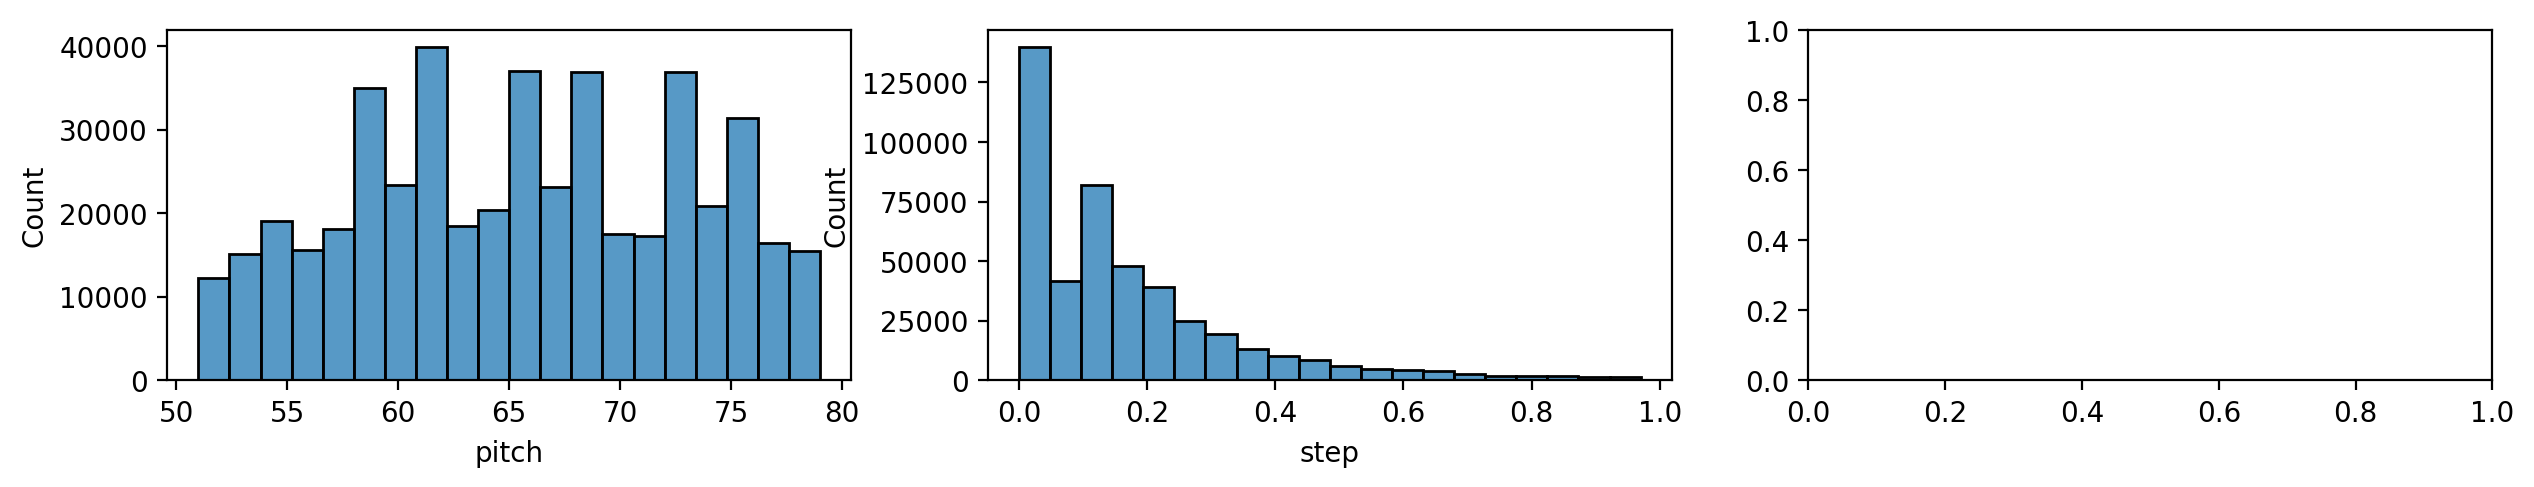

In [20]:
plot_distributions(all_notes_start)

In [21]:
all_notes, test_notes_start = train_test_split(all_notes_start, test_size=0.2, random_state=42)

In [22]:
n_notes = len(all_notes)
n_test_notes = len(test_notes_start)

print(f"Тренувальний набір містить {n_notes} нот")
print(f"Тестовий набір містить {n_test_notes} нот")

Тренувальний набір містить 376209 нот
Тестовий набір містить 94053 нот


In [23]:
key_order = ['pitch', 'step', 'duration']

train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
test_notes = np.stack([test_notes_start[key] for key in key_order], axis=1)
train_notes

array([[56, 0.2295, 'whole'],
       [62, 0.6486, '16th'],
       [75, 0.3881, 'eighth'],
       ...,
       [57, 0.0, '32nd'],
       [79, 0.0955, '16th'],
       [56, 0.0, 'eighth']], dtype=object)

In [24]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder

pitch = train_notes[:, 0].astype(np.float64)
duration = train_notes[:, 1].astype(np.float64)
label_encoder = LabelEncoder()
note_type_encoded = label_encoder.fit_transform(train_notes[:, 2]).astype(np.float64)
train_notes_encoded = np.stack([pitch, duration, note_type_encoded], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes_encoded)
notes_ds = notes_ds.map(lambda x: tf.ensure_shape(x, (3,)))

pitch = test_notes[:, 0].astype(np.float64)
duration = test_notes[:, 1].astype(np.float64)
label_encoder = LabelEncoder()
note_type_encoded = label_encoder.fit_transform(test_notes[:, 2]).astype(np.float64)
test_notes_encoded = np.stack([pitch, duration, note_type_encoded], axis=1)
test_notes_ds = tf.data.Dataset.from_tensor_slices(test_notes_encoded)
test_notes_ds = test_notes_ds.map(lambda x: tf.ensure_shape(x, (3,)))

notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

#### Create Note Sequences for Training

In [25]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
    velocity_range = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)


  def normalize_features(x):
    x = tf.stack([
        x[:, 0] / vocab_size,
        x[:, 1],
        x[:, 2]
        ], axis=-1)
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return normalize_features(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

#### Set parameters & configurations for the training dataset


In [26]:
seq_length = 50
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
test_seq_ds = create_sequences(test_notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(50, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [27]:
batch_size = 128
buffer_size = n_notes - seq_length
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

test_buffer_size = n_test_notes - seq_length
test_ds = (test_seq_ds
            .shuffle(test_buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

## Create and train the model

In [33]:
check_point_filepath = '/kaggle/input/music-lstm-attention/keras/default/5/ckpt_best.model_lstm_attention_categorical.keras'

In [29]:
def diversity_loss(y_true, y_pred, mean_penalty=2.0):
    mse = tf.square(y_true - y_pred)
    batch_mean = tf.reduce_mean(y_pred)
    clustering_penalty = mean_penalty * tf.exp(-tf.abs(y_pred - batch_mean) * 5.0)
    positive_pressure = 5.0 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + clustering_penalty + positive_pressure)

In [30]:
num_features = 3
input_shape = (seq_length, num_features)

In [39]:
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Input, Attention, Bidirectional, LSTM

inputs = tf.keras.Input(shape=input_shape)

x = Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.1))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

attention = Attention()([x, x])
x = tf.keras.layers.Add()([x, attention])

x = LSTM(128, recurrent_dropout=0.1, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu',
                        kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

In [40]:
outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(len(valid_durations), name='duration')(x)
}

In [34]:
# model = tf.keras.Model(inputs, outputs)
model = tf.keras.models.load_model(check_point_filepath,
                                   custom_objects={'diversity_loss': diversity_loss})

In [44]:
loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      'step': diversity_loss,
      'duration': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
}

In [45]:
learning_rate = 0.00001
optimizer = tf.keras.optimizers.Adam(clipvalue=1.0, learning_rate=learning_rate)
model.compile(loss=loss, loss_weights={
        'pitch': 1.0,
        'step': 1.0,
        'duration': 1.0
    },
    optimizer='adam')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50, 3)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50, 512)        │        532,480 │ input_layer[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 50, 512)        │          2,048 │ bidirectional[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50, 512)        │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 50, 512)        │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 50, 512)        │              0 │ dropout[0][0],         │
│                           │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 128)            │        328,192 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128)            │            512 │ lstm_1[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         16,512 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128)            │            512 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration (Dense)          │ (None, 12)             │          1,548 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pitch (Dense)             │ (None, 128)            │         16,512 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ step (Dense)              │ (None, 1)              │            129 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 898,445 (3.43 MB)

 Trainable params: 896,909 (3.42 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [60]:
callbacks = [
  tf.keras.callbacks.ModelCheckpoint(
    filepath=check_point_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min'),
  tf.keras.callbacks.EarlyStopping(
      monitor='loss',
      patience=3,
      verbose=1,
      restore_best_weights=True),
  tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.5,
      patience=3,
      min_lr=0.0001),
  tf.keras.callbacks.TensorBoard(log_dir='/kaggle/working/logs', histogram_freq=1)
]

In [67]:
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    initial_epoch=27,
    validation_data=test_ds,
    callbacks=callbacks
)

Epoch 28/50
   2938/Unknown 348s 99ms/step - duration_loss: 1.5853 - loss: 5.6288 - pitch_loss: 3.2616 - step_loss: 0.6704

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2938/2938 ━━━━━━━━━━━━━━━━━━━━ 390s 113ms/step - duration_loss: 1.5853 - loss: 5.6288 - pitch_loss: 3.2616 - step_loss: 0.6705 - val_duration_loss: 6.0130 - val_loss: 10.1318 - val_pitch_loss: 3.2441 - val_step_loss: 0.7511 - learning_rate: 0.0010
Epoch 29/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 319s 108ms/step - duration_loss: 1.5845 - loss: 5.6208 - pitch_loss: 3.2588 - step_loss: 0.6685 - val_duration_loss: 5.8044 - val_loss: 11.5046 - val_pitch_loss: 3.2433 - val_step_loss: 2.2868 - learning_rate: 0.0010
Epoch 30/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 320s 109ms/step - duration_loss: 1.5840 - loss: 5.6751 - pitch_loss: 3.2580 - step_loss: 0.6798 - val_duration_loss: 5.9861 - val_loss: 10.1832 - val_pitch_loss: 3.2447 - val_step_loss: 0.7910 - learning_rate: 0.0010
Epoch 31/50
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 320s 109ms/step - duration_loss: 1.5838 - loss: 5.6500 - pitch_loss: 3.2569 - step_loss: 0.6746 - val_duration_loss: 5.9239 - val_loss: 10.1034 - val_pitch_loss: 3.2430 - val_step_loss: 0.8

In [ ]:
model.save(check_point_filepath)

In [6]:
# !kill 58
# %load_ext tensorboard
!tensorboard --logdir=/kaggle/working/logs --bind_all

2025-04-06 10:09:51.164637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-06 10:09:51.194329: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-06 10:09:51.203273: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.17.1 at http://2d3ee4fccd2a:6006/ (Press CTRL+C to quit)
^C


In [47]:
test_loss = model.evaluate(train_ds, return_dict=True)
print("Оцінка на тестовому наборі:", test_loss)

2938/2938 ━━━━━━━━━━━━━━━━━━━━ 742s 225ms/step - duration_loss: 2.5621 - loss: 11.3083 - pitch_loss: 4.9246 - step_loss: 3.1815
Оцінка на тестовому наборі: {'duration_loss': 2.561075448989868, 'loss': 11.303401947021484, 'pitch_loss': 4.923130035400391, 'step_loss': 3.17928147315979}


In [1]:
# Plot total loss
plt.plot(history.epoch, history.history['loss'], label='Total Loss')
plt.plot(history.epoch, history.history['duration_loss'], label='Duration Loss')
plt.plot(history.epoch, history.history['pitch_loss'], label='Pitch Loss')
plt.plot(history.epoch, history.history['step_loss'], label='Step Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Metrics Over Epochs')

plt.legend()

plt.show()

NameError: name 'plt' is not defined

## Generate notes

In [35]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration_logits = predictions['duration']

  # Process pitch with temperature scaling and categorical sampling
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)

  # Extract and squeeze other predictions
  duration = tf.random.categorical(duration_logits, num_samples=1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)

  return int(pitch), float(step), float(duration)

In [36]:
def find_key_by_value(dict_obj, value):
    for key, val in dict_obj.items():
        if val == value:
            return key
    return None

In [37]:
def convert_duration_to_seconds(duration_value, bpm):
    # Тривалість цілої ноти в секундах
    duration_of_one_beat = (60 / bpm) * 4
    if isinstance(duration_value, pd.Series):
        duration_value = duration_value.item()
    key = find_key_by_value(valid_durations, duration_value)
    duration_in_seconds = duration_of_one_beat / key
    return duration_in_seconds

# Приклад:
bpm = 120
note_durations = ['whole', '16th', 'quarter', 'half', '32nd', 'eighth']

for note in note_durations:
    duration_in_seconds = convert_duration_to_seconds(note, bpm)
    print(f"Note {note} corresponds to {duration_in_seconds:.4f} seconds.")


Note whole corresponds to 2.0000 seconds.
Note 16th corresponds to 0.1250 seconds.
Note quarter corresponds to 0.5000 seconds.
Note half corresponds to 1.0000 seconds.
Note 32nd corresponds to 0.0625 seconds.
Note eighth corresponds to 0.2500 seconds.


In [38]:
temperature = 1.5
num_predictions = 150
bpm = 220
velocity_range = 128

sample_notes = np.stack([all_notes[50:100][key] for key in key_order], axis=1)

# The normalization factors for each feature
normalization_factors = np.array([
    vocab_size,
    1,
    1
])

pitch = train_notes[:, 0].astype(np.float64)
duration = train_notes[:, 1].astype(np.float64)
label_encoder = LabelEncoder()
note_type_encoded = label_encoder.fit_transform(train_notes[:, 2]).astype(np.float64)
sample_notes = np.stack([pitch, duration, note_type_encoded], axis=1)

# sequences
input_notes = (
    sample_notes[:seq_length] /normalization_factors)

# start generating notes
generated_notes = []
prev_pitch = input_notes[-1, 0] * vocab_size
prev_start = 0

for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)

  duration_label = label_encoder.inverse_transform(np.array([int(duration)]))

  duration_in_seconds = convert_duration_to_seconds(duration_label, bpm)
    
  start = prev_start + step
  end = start + duration_in_seconds

  normalized_pitch = pitch / vocab_size

  next_input_note = np.array([normalized_pitch, step, duration])

  generated_notes.append((pitch, step, duration_label, start, end))

  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(next_input_note, 0), axis=0)

  prev_start = start
  prev_pitch = pitch

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

### Create a MIDI file (Tensorflow, 2021)

In [39]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  bpm = 120,
  velocity: int = 100,
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    duration_in_seconds = convert_duration_to_seconds(note['duration'], bpm)
    start = float(prev_start + note['step'])
    end = float(start + duration_in_seconds)
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [40]:
generated_notes

,pitch,step,duration,start,end
0,77,0.872708,[quarter],0.872708,1.145436
1,64,0.137534,[eighth],1.010242,1.146606
2,65,0.137923,[16th],1.148165,1.216347
3,69,0.869766,[16th],2.017931,2.086113
4,68,0.871577,[16th],2.889508,2.957690
...,...,...,...,...,...
145,59,0.870662,[16th],63.442195,63.510377
146,70,0.870330,[16th],64.312525,64.380707
147,56,0.869623,[eighth],65.182148,65.318512
148,71,0.137976,[16th],65.320124,65.388306


In [47]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name='Acoustic Grand Piano')
display_audio(out_pm)